In [1]:
%load_ext autoreload
%autoreload 2

## Setup

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim


In [3]:
jax.__version__, _galsim.__version__


('0.4.29', '2.5.3')

In [4]:
jax.devices()


[cuda(id=0)]

In [5]:
jax.config.update("jax_default_device", jax.devices()[0])


In [6]:
import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put


2024-06-13 11:57:50.038614: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tqdm import tqdm


In [9]:
# import bpd
# from bpd.chains import run_chains
# from bpd.draw import add_noise


In [10]:
from numpyro.diagnostics import summary, gelman_rubin, effective_sample_size, print_summary


## Fit single gaussian galaxy with shear (and other parameters)

In [38]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 51
BACKGROUND = 1e4

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 4.5
TRUE_FLUX = 10**LOG_TRUE_FLUX
TRUE_X = 0.
TRUE_Y = 0.
 
#shear
G1 = 0.25
G2 = 0.0

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR, 'x': TRUE_X, 'y': TRUE_Y, 'g1': G1, 'g2': G2}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}


In [39]:

def add_noise(x: np.ndarray, bg: float, n=1, noise_factor=1):
    """Produce `n` independent Gaussian noise realizations of a given image `x`.

    NOTE: This function assumes image is background-subtracted and dominated.
    """
    x = x.reshape(1, *x.shape)
    x = x.repeat(n, axis=0)
    noise = np.random.randn(*x.shape) * np.sqrt(bg) * noise_factor
    return x + noise, noise

In [40]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    gal = gal.shear(g1=G1, g2=G2)
    pos = _galsim.PositionD(x=TRUE_X, y=TRUE_Y)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos)
    im = gal_conv.array
    return im


In [41]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf, hlr, x, y, g1, g2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos, 
                                 )
    return image.array


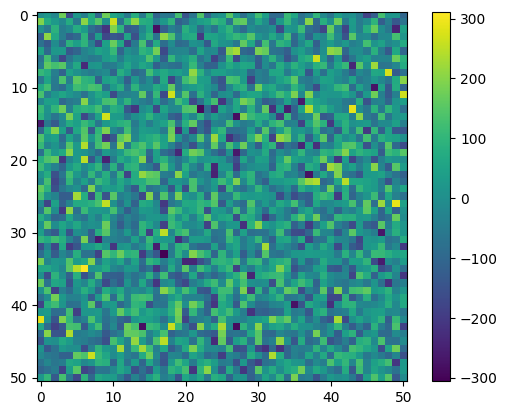

In [46]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gal()
im, _ = add_noise(TRUE_IMAGE, BACKGROUND)
arr = im - draw_gal(**TRUE_PARAMS_ARR)
plt.imshow(arr[0])
plt.colorbar()


In [47]:
x1 = TRUE_IMAGE
np.sqrt(np.sum( (x1 * x1) / (x1 + BACKGROUND)))

17.98962

In [48]:
def prob_model(data):
    batch_dim, _, _ = data.shape
    with numpyro.plate('b', batch_dim, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(4,6))
        hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
        x = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
        y = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
        g1 = numpyro.sample('g1', dist.Uniform(-0.4, 0.4))
        g2 = numpyro.sample('g2', dist.Uniform(-0.4, 0.4))
    im = draw_gal(lf, hlr, x, y, g1, g2)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)


In [52]:
data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=2)
nuts_kernel = NUTS(prob_model, max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_warmup=250, num_samples=200, num_chains=1)
rng_key = random.PRNGKey(43)
mcmc.run(rng_key, data=data)


sample: 100%|██████████| 450/450 [00:17<00:00, 25.17it/s, 15 steps of size 3.32e-01. acc. prob=0.94] 


In [53]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g1[0]      0.26      0.07      0.27      0.15      0.37    190.63      1.00
     g1[1]      0.33      0.05      0.34      0.27      0.40    238.60      1.02
     g2[0]      0.29      0.07      0.31      0.19      0.40    127.77      1.02
     g2[1]      0.15      0.07      0.16      0.05      0.28    253.86      1.00
    hlr[0]      0.85      0.09      0.85      0.70      0.97    158.49      1.00
    hlr[1]      1.01      0.08      1.01      0.86      1.14    112.48      1.02
     lf[0]      4.51      0.03      4.51      4.46      4.56    145.08      1.00
     lf[1]      4.56      0.03      4.56      4.51      4.61    137.06      1.00
      x[0]     -0.03      0.28     -0.03     -0.49      0.36    163.66      1.00
      x[1]     -0.05      0.27     -0.03     -0.48      0.31    179.54      1.00
      y[0]      0.03      0.26      0.05     -0.35      0.50    415.12      1.00
      y[1]     -0.05      0

In [36]:
samples = mcmc.get_samples()
samples = {k:v[:,0] for k,v in samples.items()}

In [37]:
print_summary(mcmc.get_samples(), group_by_chain=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g1[0]      0.03      0.02      0.03      0.00      0.08    127.46      1.04
     g2[0]     -0.02      0.03     -0.02     -0.06      0.03    113.59      0.99
    hlr[0]      0.87      0.02      0.87      0.84      0.91     49.41      0.99
     lf[0]      5.00      0.01      5.00      4.98      5.01     84.45      0.99
      x[0]      0.17      0.11      0.19      0.04      0.34    106.10      1.01
      y[0]      0.02      0.11      0.01     -0.12      0.25    107.34      1.00



In [38]:
samples['g1'].std()

Array(0.02306454, dtype=float32)

In [45]:
gelman_rubin(samples['g1'].reshape(1, 100))

AssertionError: 

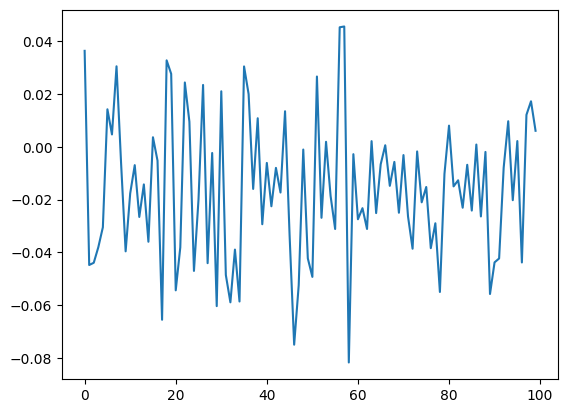

In [43]:
plt.plot(samples['g2'])

Parameter g2 in chain Posterior is not constrained


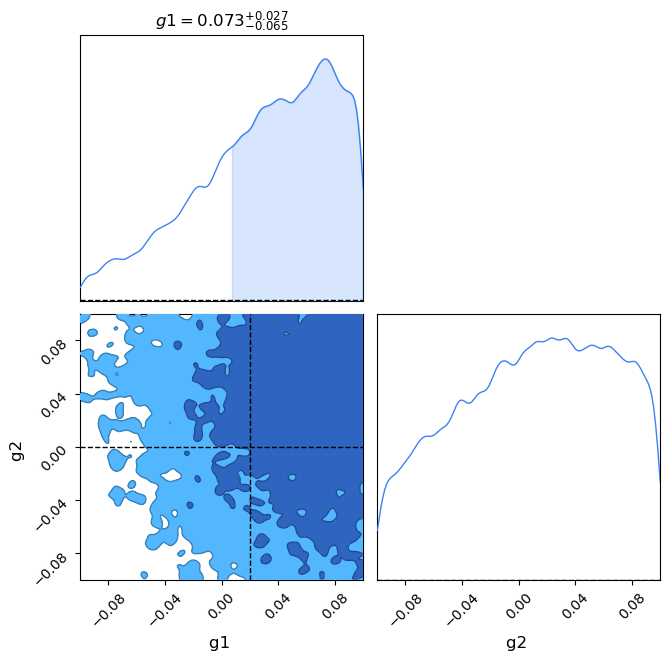

In [75]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
samples = {k:samples[k] for k in ['g1', 'g2']}
df =pd.DataFrame.from_dict(samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location={'g1':0.02, 'g2':0.0}))
fig = c.plotter.plot()

In [76]:
# collect samples
samples = {p:np.zeros((2000, n_chains*n_vec)) for p in all_samples[0]}
for ii in range(n_chains):
    for p in all_samples[ii]:
        p_ii = all_samples[ii][p]
        samples[p][:, ii*n_vec:(ii+1)*n_vec] = p_ii


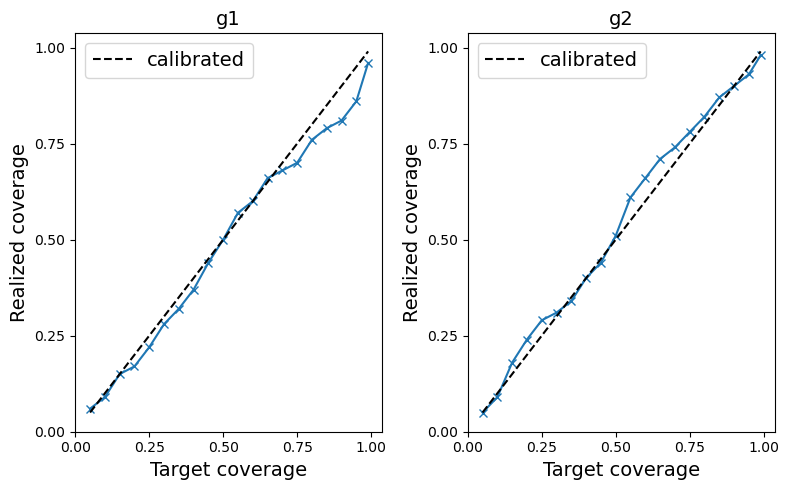

In [84]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
get_pc_fig(samples['g1'], G1, ax1, param='g1')
get_pc_fig(samples['g2'], G2, ax2, param='g2')
plt.tight_layout()


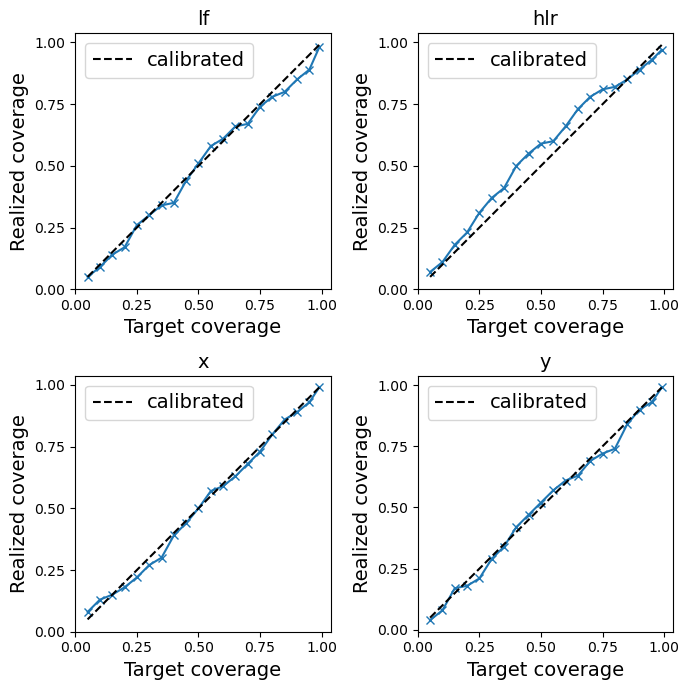

In [90]:
fig, [[ax1, ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(7,7))
get_pc_fig(samples['lf'], LOG_TRUE_FLUX, ax1, param='lf')
get_pc_fig(samples['hlr'], TRUE_HLR, ax2, param='hlr')
get_pc_fig(samples['x'], TRUE_X, ax3, param='x')
get_pc_fig(samples['y'], TRUE_Y, ax4, param='y')
plt.tight_layout()
